In [920]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

**Example: Forward propagation**

$$Z^{[1]} = W^{[1]} X + b^{[1]}$$
$$A^{[1]} = g_{\text{ReLU}}(Z^{[1]}))$$
$$Z^{[2]} = W^{[2]} A^{[1]} + b^{[2]}$$
$$A^{[2]} = g_{\text{ReLU}}(Z^{[2]}))$$
$$Z^{[3]} = W^{[3]} A^{[2]} + b^{[3]}$$
$$A^{[3]} = g_{\text{softmax}}(Z^{[3]})$$

In [921]:
def one_hot(Y):
    one_hot_Y = np.zeros((Y.size, 10))
    one_hot_Y[np.arange(Y.size), Y] = 1
    one_hot_Y = one_hot_Y.T
    return one_hot_Y
    

In [922]:
class Linear:

    def __init__(self,n_inputs,n_outputs):
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        self.weights = np.random.rand(n_inputs,n_outputs) - 0.5
        self.biases = np.zeros((1,n_outputs))
    def forward(self,X):
        self.X = X
        self.Z = self.X.dot(self.weights) + self.biases
        return self.Z
    def backward(self,Layer):
        dz_dw = self.X
        dz_db = np.ones_like(Layer.dbackward)
        dz_dA = self.weights
        self.dweights = dz_dw.T.dot(Layer.dbackward)
        self.dbiases = np.sum(Layer.dbackward,axis=0,keepdims=True)
        self.dbackward =Layer.dbackward.dot(dz_dA.T)
class ReLU:
    def forward(self,X):
        self.A = np.maximum(0,X)
        return self.A
        
    def backward(self,Layer):
        dA_dz = np.where(Layer.dbackward>0,1,0)
        self.dbackward = np.multiply(Layer.dbackward,dA_dz)
    
class SoftMax:
    def forward(self,X):
        c = np.max(X,axis=1).reshape(-1,1)
        Y = np.exp(X-c) / np.sum(np.exp(X-c),axis=1,keepdims=True)
        self.output = Y
        return Y
    def backward(self,Layer):
        clone_matrix = np.array*([self.Y,]*len(self.Y))
        jacobian_matrix = np.diag(self.Y) - np.multiply(clone_matrix,clone_matrix.T)
        self.dbackward = Layer.dbackward @ jacobian_matrix
class MSELoss:
    def forward(self,Y_pred,Y_true):
        self.Y_pred = Y_pred
        self.Y_true = Y_true
        self.loss = ((Y_pred-Y_true)**2).mean()
        return self.loss
    def backward(self):
        self.dbackward = 2* (self.Y_pred - self.Y_true)
        
class CategoricalCrossEntropyLoss:
    def forward(self,y_pred,y_true):
        self.loss = -np.max(np.log(y_pred),axis=1)
    def backward(self,y_pred,y_true):
        self.dbackward = (y_pred - one_hot(y_true).T) / len(y_true)
        
    
class OptimizerSGD:
    def __init__(self,lr=0.1):
        self.lr = lr
    def update_params(self,Layer):
        Layer.weights -= self.lr * Layer.dweights
        Layer.biases -= self.lr * Layer.dbiases


In [923]:
class NeuralNetwork:
    def __init__(self,n_inputs,n_outputs):
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        self.linear1 = Linear(n_inputs=self.n_inputs,n_outputs=64)
        self.relu1 = ReLU()
        self.linear2 = Linear(n_inputs=64,n_outputs=128)
        self.relu2 = ReLU()
        self.linear3 = Linear(n_inputs=128,n_outputs=self.n_outputs)
        self.softmax = SoftMax()
        self.loss = CategoricalCrossEntropyLoss()
    def forward(self,X):
        X = self.linear1.forward(X)
        X = self.relu1.forward(X)
        X = self.linear2.forward(X)
        X = self.relu2.forward(X)
        X = self.linear3.forward(X)
        X = self.softmax.forward(X)
        return X
    
    def calculate_loss(self,y_pred,y_true):
        self.loss.forward(y_pred,y_true)
        
    def backward(self):
        self.loss.backward(self.softmax.output,self.y)
        self.linear3.backward(self.loss)
        self.relu2.backward(self.linear3)
        self.linear2.backward(self.relu2)
        self.relu1.backward(self.linear2)
        self.linear1.backward(self.relu1)
    
    def update(self):
        optim = OptimizerSGD(lr=self.lr)
        optim.update_params(self.linear1)
        optim.update_params(self.linear2)
        optim.update_params(self.linear3)
    
    def prediction(self,y_pred):
        return np.argmax(y_pred,axis=1)
    def accuracy(self,y_pred,y_true):
        return sum(self.prediction(y_pred)==y_true) / len(y_pred)
    def fit(self,X,y,epochs = 1000,lr=0.1):
        self.X = X
        self.y = y
        self.lr = lr
        for i in range(epochs):
            y_pred = self.forward(X)
            self.calculate_loss(y_pred,y)
            self.backward()
            self.update()
            if i%10==0:
                print(f"Epochs {i}: {self.prediction(y_pred)} {self.y}")
                print(f"Accuracy: {self.accuracy(y_pred,y)}")
                



In [924]:
data = pd.read_csv('train.csv')

In [925]:
data = np.array(data)
np.random.shuffle(data)
data = data.T
X_train = data[1:].T / 255.
y_train = data[0]

Label: 5


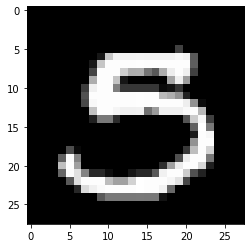

In [926]:
index = 3456
plt.gray()
plt.imshow(X_train[index].reshape(28,28),interpolation='nearest')
print(f'Label: {y_train[index]}')

In [934]:
model = NeuralNetwork(n_inputs=784,n_outputs=10)
model.fit(X_train[:5],y_train[:5],epochs=100,lr=0.1)

Epochs 0: [0 0 0 0 0] [9 3 3 4 2]
Accuracy: 0.0
Epochs 10: [9 3 3 4 2] [9 3 3 4 2]
Accuracy: 1.0
Epochs 20: [9 3 3 4 2] [9 3 3 4 2]
Accuracy: 1.0
Epochs 30: [9 3 3 4 2] [9 3 3 4 2]
Accuracy: 1.0
Epochs 40: [9 3 3 4 2] [9 3 3 4 2]
Accuracy: 1.0
Epochs 50: [9 3 3 4 2] [9 3 3 4 2]
Accuracy: 1.0
Epochs 60: [3 3 3 4 2] [9 3 3 4 2]
Accuracy: 0.8
Epochs 70: [3 3 3 2 2] [9 3 3 4 2]
Accuracy: 0.6
Epochs 80: [3 3 3 3 2] [9 3 3 4 2]
Accuracy: 0.6
Epochs 90: [3 3 3 3 2] [9 3 3 4 2]
Accuracy: 0.6


In [928]:
s = np.array([[1,2,3],[4,6,5],[233,8,9]])
s / np.max(s,axis=1).reshape(-1,1)

array([[0.33333333, 0.66666667, 1.        ],
       [0.66666667, 1.        , 0.83333333],
       [1.        , 0.03433476, 0.03862661]])

In [929]:
y_pred = model.forward(X_train)
-np.multiply(np.log(y_pred),one_hot(y_train).T)[:5]

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 6.01691086e-04],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.16383548e-03,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 3.39993808e-04,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        1.48733657e+01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 4.66455791e+01, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00]])

In [930]:
np.max(np.log(y_pred),axis=1)

array([-0.00060169, -0.00216384, -0.00033999, ..., -0.30569674,
       -0.14476499, -0.00450841])

In [931]:
X_train[:2]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [932]:
y_train[:2]

array([9, 3], dtype=int64)